# Testing Tabular SR

In [1]:
try:
    import google.colab
    COLAB = True
except ModuleNotFoundError:
    COLAB = False
    pass

if COLAB:
    !pip -q install "gymnasium[classic-control, atari, accept-rom-license]"
    !pip -q install piglet
    !pip -q install imageio_ffmpeg
    !pip -q install moviepy==1.0.3

In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from functools import partial
from IPython.display import clear_output

%matplotlib inline

In [3]:
MOVE_DIRECTIONS = {
    # (i, j)-based coordinates [or (y, x) for the viewer]
    'right': (0, 1), 'down': (1, 0), 'left': (0, -1), 'up': (-1, 0)
}
DIRECTIONS_ORDER = ['right', 'down', 'left', 'up']
TURN_DIRECTIONS = {'right': 1, 'left': -1}


class MoveDynamics:
    @staticmethod
    def try_move(
            position: tuple[int, int], move_direction: tuple[int, int],
            shape: tuple[int, int], obstacle_mask: np.ndarray
    ):
        """
        Performs the move if it's allowed.
        Returns new position and flag whether or not the move was successful.
        """
        new_position = MoveDynamics.move(position, move_direction)
        new_position = MoveDynamics.clip2d(new_position, shape)

        success = MoveDynamics.is_move_successful(position, new_position, obstacle_mask)
        if not success:
            new_position = position
        return new_position, success

    @staticmethod
    def is_move_successful(
            position: tuple[int, int], new_position: tuple[int, int],
            obstacle_mask: np.ndarray
    ):
        """Checks whether move is happened and is allowed."""
        # changed position but not stepped into the wall
        return new_position != position and not obstacle_mask[new_position]

    @staticmethod
    def move(position: tuple[int, int], direction: tuple[int, int]):
        """
        Calculates new position for the move to the specified direction
        without checking whether this move is allowed or not.
        """
        i, j = position
        i += direction[0]
        j += direction[1]
        return i, j

    @staticmethod
    def clip2d(position: tuple[int, int], shape: tuple[int, int]):
        """Clip position to be inside specified rectangle."""
        def clip(x, high):
            if x >= high:
                return high - 1
            if x < 0:
                return 0
            return x
        i, j = position
        i = clip(i, shape[0])
        j = clip(j, shape[1])
        return i, j


In [4]:
def get_four_rooms_obstacles():
    four_rooms_obstacles = """
-------x--------
-------x--------
-------x--------
----------------
-------x--------
-------x--------
-------x--------
-------x--------
xxx-xxxxxxxxx-xx
--------x-------
--------x-------
--------x-------
--------x-------
--------x-------
----------------
--------x-------
--------x-------
"""
    return np.array([
        [int(c == 'x') for c in row]
        for row in four_rooms_obstacles.strip().split('\n')
    ])


four_rooms_obstacles = get_four_rooms_obstacles()
print(four_rooms_obstacles.shape)
four_rooms_obstacles

(17, 16)


array([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]])

In [5]:
def get_clean_room_obstacles(size):
    return np.zeros((size, size), dtype=int)

get_clean_room_obstacles(8)

array([[0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]])

In [27]:
from numpy.random import Generator

TPos = tuple[int, int]
TSize2d = tuple[int, int]

class GridWorld:
    size: TSize2d
    init_agent_pos: TPos
    obstacles: np.ndarray
    
    agent_pos: TPos
    
    terminal: TPos
    reward: float
    const_punish: float
    terminal_decay: float
    time_limit: int | None

    observation_type: str
    pixel_size: int
    color_map: dict
    
    _pos: TPos
    _obs: np.ndarray
    _step: int
    _terminated: bool
    _next_pos_cache: dict[tuple[TPos, int], TPos]
    
    def __init__(
        self,
        *,
        size: TSize2d, 
        agent: TPos = None,
        obstacle_mask: np.ndarray = None,
        terminal: TPos = None,
        reward: float = None,
        const_punish: float = 0.,
        terminal_decay: float = 1.0,
        time_limit: int = None,
        pixel_size: int = 1,
        color_map: dict = None,
        observation_type: str = 'state'
    ):
        self.size = size
        self.init_agent_pos = agent
        
        self.action_space = gym.spaces.Discrete(4)
        self.observation_type = observation_type
        if self.observation_type == 'img':
            self.observation_space = gym.spaces.Box(0., 1., shape=self.size, dtype=np.float)
        elif self.observation_type == 'state':
            self.observation_space = gym.spaces.Discrete(np.prod(self.size))
        elif self.observation_type == 'pos':
            self.observation_space = gym.spaces.Box(
                low=np.array([0, 0], dtype=np.int),
                high=np.array(self.size, dtype=np.int) - 1,
                shape=(2,), dtype=np.int
            )
        else:
            raise ValueError(f'Observation type {self.observation_type} is not supported')
        
        self.obstacles = np.zeros(self.size, dtype=int)
        if obstacle_mask is not None:
            self.obstacles[:] = obstacle_mask

        self.terminal = terminal
        self.reward = reward
        assert const_punish >= 0., 'I expect negative punish'
        self.const_punish = const_punish
        assert terminal_decay <= 1., 'I expect terminal reward decaying, i.e. terminal_decay <= 1.0'
        self.terminal_decay = terminal_decay
        
        self.time_limit = time_limit
        
        self.pixel_size = pixel_size
        self.color_map = color_map

        self._pos = self.init_agent_pos
        self._obs = self._get_initial_observation()
        self._next_pos_cache = {}
        self.reset()
    
    def reset(self, seed=None):
        self.action_space = gym.spaces.Discrete(4, seed=seed)
        self._rng = np.random.default_rng(seed)

        # do not forget to update observation
        #   1) regularly: old pos -> floor; init pos -> agent
        self._update_observation(self._pos, self.init_agent_pos)
        #   2) restore target if it was overwritten: terminal -> target
        self._fill(self.terminal, self.color_map['target'])

        self._pos = self.init_agent_pos
        self._step = 0
        self._terminated = self._is_current_pos_terminal()

        img, pos, state = self._obs, self._pos, self.to_state(self._pos)
        info = dict(img=img, pos=pos, state=state)
        return info[self.observation_type], info
    
    def step(self, action):
        assert not self._terminated

        self._step += 1
        self._pos = self._move(action)

        # move before getting the reward
        reward = self._get_reward()
        
        # update terminated state after getting the reward
        terminated = self._is_current_pos_terminal()
        truncated = self.time_limit is not None and self._step >= self.time_limit
        self._terminated = terminated or truncated

        img, pos, state = self._obs, self._pos, self.to_state(self._pos)
        info = dict(img=img, pos=pos, state=state)
        
        return info[self.observation_type], reward, terminated, truncated, info

    def to_state(self, pos: TPos):
        return pos[0] * self.size[1] + pos[1]

    def render(self):
        return self._obs
    
    def render_rgb(self):
        plt.imshow(self._obs)
        
    def _is_current_pos_terminal(self) -> bool:
        return self._pos == self.terminal
    
    def _get_reward(self) -> float:
        reward = 0
        if self._pos == self.terminal and not self._terminated:
            reward += self.terminal_decay ** self._step
        reward -= self.const_punish
        return reward
    
    def _move(self, action) -> TPos:
        new_pos = self._next_pos_cache.get((self._pos, action), None)
        if new_pos is None:
            # call true dynamics to get new position
            new_pos, _ = MoveDynamics.try_move(
                position=self._pos,
                move_direction=MOVE_DIRECTIONS[DIRECTIONS_ORDER[action]],
                shape=self.size, obstacle_mask=self.obstacles
            )
            self._next_pos_cache[(self._pos, action)] = new_pos
        
        # update observation after move
        self._update_observation(self._pos, new_pos)
        return new_pos
    
    def _get_initial_observation(self) -> np.ndarray:
        # make observation map with pixel positions
        obs = np.zeros(self.size)
        obs[self.obstacles == 0] = self.color_map['floor']
        obs[self.obstacles == 1] = self.color_map['obstacle']
        obs[self.terminal] = self.color_map['target']
        obs[self._pos] = self.color_map['agent']
        
        # then resize observation transforming each pixel to the square
        px = self.pixel_size
        return np.repeat(np.repeat(obs, px, axis=0), px, axis=1)
        
    
    def _update_observation(self, pos, new_pos):
        # fill old pos with floor color, fill new pos with agent color
        px = self.pixel_size
        floor, agent = self.color_map['floor'], self.color_map['agent']
        
        self._fill(pos, floor)
        self._fill(new_pos, agent)
            
    def _fill(self, pos, color):
        # fill position with the color
        (i, j), px = pos, self.pixel_size
        i, j = i*px, j*px
        self._obs[i:i+px, j:j+px] = color

In [28]:
def make_env(
    observation_type: str, # 'img' / 'state' / 'pos'
    obstacle_mask, agent, terminal,
    const_punish=0., terminal_decay=0.99, time_limit=50, pixel_size=2
):
    return GridWorld(
        size=obstacle_mask.shape, 
        obstacle_mask=obstacle_mask,
        agent=agent, terminal=terminal,
        const_punish=const_punish, terminal_decay=terminal_decay,
        time_limit=time_limit,
        pixel_size=pixel_size, color_map=dict(floor=.3, obstacle=.02, agent=.6, target=.9),
        observation_type=observation_type
    )

def make_four_rooms(**kwargs):
    four_rooms_obstacles = get_four_rooms_obstacles()  
    return make_env(obstacle_mask=four_rooms_obstacles, **kwargs)

def make_clean_room(size, **kwargs):
    clean_room_obstacles = get_clean_room_obstacles(size)
    return make_env(obstacle_mask=clean_room_obstacles, **kwargs)

(34, 0.0, False, False, {'img': array([[0.3, 0.3, 0.3, ..., 0.3, 0.3, 0.3],
       [0.3, 0.3, 0.3, ..., 0.3, 0.3, 0.3],
       [0.3, 0.3, 0.3, ..., 0.3, 0.3, 0.3],
       ...,
       [0.3, 0.3, 0.3, ..., 0.3, 0.3, 0.3],
       [0.3, 0.3, 0.3, ..., 0.3, 0.9, 0.9],
       [0.3, 0.3, 0.3, ..., 0.3, 0.9, 0.9]]), 'pos': (2, 2), 'state': 34})


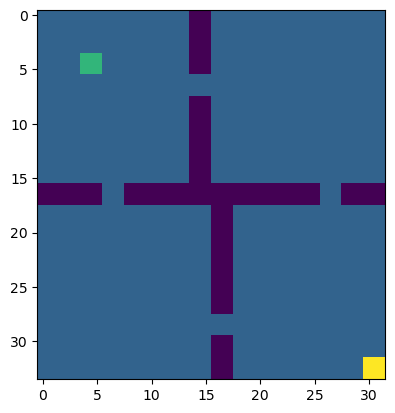

In [29]:
env = make_four_rooms(
    agent=(0, 0), terminal=(16,15), 
    const_punish=0., terminal_decay=0.99,
    time_limit=50, pixel_size=2,
    observation_type='state'
)
env.reset()
env.step(1)
env.step(0)
env.step(1)
print(env.step(0))
env.render_rgb()

(18, 0.0, False, False, {'img': array([[0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
        0.3, 0.3, 0.3],
       [0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
        0.3, 0.3, 0.3],
       [0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
        0.3, 0.3, 0.3],
       [0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
        0.3, 0.3, 0.3],
       [0.3, 0.3, 0.3, 0.3, 0.6, 0.6, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
        0.3, 0.3, 0.3],
       [0.3, 0.3, 0.3, 0.3, 0.6, 0.6, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
        0.3, 0.3, 0.3],
       [0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
        0.3, 0.3, 0.3],
       [0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
        0.3, 0.3, 0.3],
       [0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
        0.3, 0.3, 0.3],
       [0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
        0.3, 0.3, 0.3]

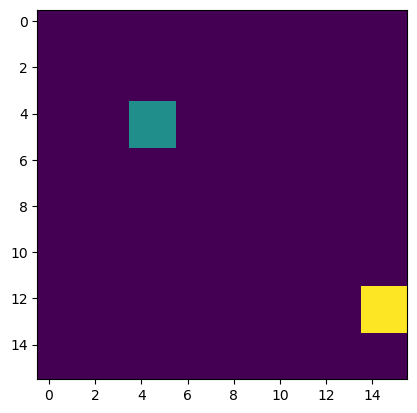

In [30]:
env = make_clean_room(
    size=8,
    agent=(0, 0), terminal=(6,7), 
    const_punish=0., terminal_decay=0.99,
    time_limit=50, pixel_size=2,
    observation_type='state'
)
env.reset()
env.step(1)
env.step(0)
env.step(1)
print(env.step(0))
env.render_rgb()

In [17]:
def show_progress(avg_returns):
    """
    Удобная функция, которая отображает прогресс обучения.
    """
    clear_output(True)
    plt.figure(figsize=[12, 4])
    plt.subplot(1, 1, 1)
    plt.plot(*zip(*avg_returns), label='Mean return')
    plt.legend(loc=4)
    plt.grid()
    plt.show()

def compare_logs(logs):
    """Функция сравнения кривых обучения"""
    plt.figure(figsize=[12, 6])
    for log, method_name in logs:
        plt.plot(*zip(*log), label=f'{method_name}')
        plt.legend()
    plt.grid()
    plt.show()

In [66]:
rooms = np.array([
    [[0, 8], [0, 7]],
    [[0, 8], [8, 16]],
    [[9, 17], [0, 8]],
    [[9, 17], [9, 16]]
])
def sample_point_in_room(n, rng=None):
    if rng is None or isinstance(rng, int):
        rng = np.random.default_rng(rng)
    room = rooms[n]
    return rng.integers(*room[0]), rng.integers(*room[1])

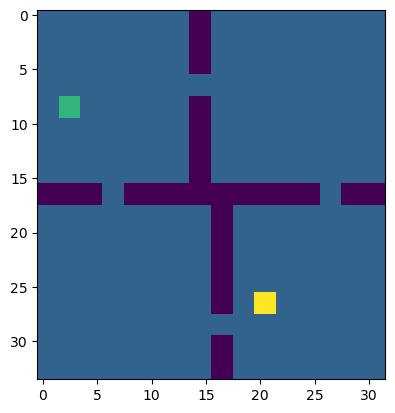

In [89]:
# env = gym.make("Taxi-v3", render_mode="rgb_array")
env = make_four_rooms(
    # size=8,
    agent=sample_point_in_room(0, 12),
    terminal=sample_point_in_room(3, 12), 
    const_punish=0., terminal_decay=0.99,
    time_limit=50, pixel_size=2,
    observation_type='state'
)
env.reset(seed=13)
plt.imshow(env.render())

## Q-learning

In [117]:
class DecayVal:
    val: float
    decay: float
    schedule: int
    def __init__(self, val, decay, schedule):
        self.val = val
        self.decay = decay
        self.i = 0
        self.schedule = schedule

    def __call__(self):
        return self.val

    def step(self):
        self.i += 1
        if self.i % self.schedule == 0:
            self.val *= self.decay

    def copy(self):
        return DecayVal(self.val, self.decay, self.schedule)


class QAgent:
    def __init__(self, n_states, n_actions, lr, gamma, eps, seed):
        self.Q = np.zeros((n_states, n_actions))
        self.lr = lr
        self.gamma = gamma
        self.eps = eps
        self.n_actions = n_actions
        self._rng = np.random.default_rng(seed)

    def reset(self):
        self.eps.step()
        self.lr.step()
        
    def act(self, s):
        # выбираем действие, используя eps-greedy исследование среды
        # с вероятностью epsilon выбираем случайное действие, иначе
        # выполняем действие жадно, согласно текущей Q-таблице
        if self._rng.random() < self.eps():
            action = self._rng.choice(self.n_actions)
        else:
            action = np.argmax(self.Q[s])  # используем Q-функцию
        return action

    def update(self, s, a, r, s_n, done):
        # реализуйте шаг Q-обучения
        # получаем old_value (Q(s,a)) и next_max (max(Q(s', a')))
        Q_s_a = self.Q[s, a]
        V_sn = np.max(self.Q[s_n])

        td_error = r + self.gamma * (1-done) * V_sn - Q_s_a
        self.Q[s, a] += self.lr() * td_error

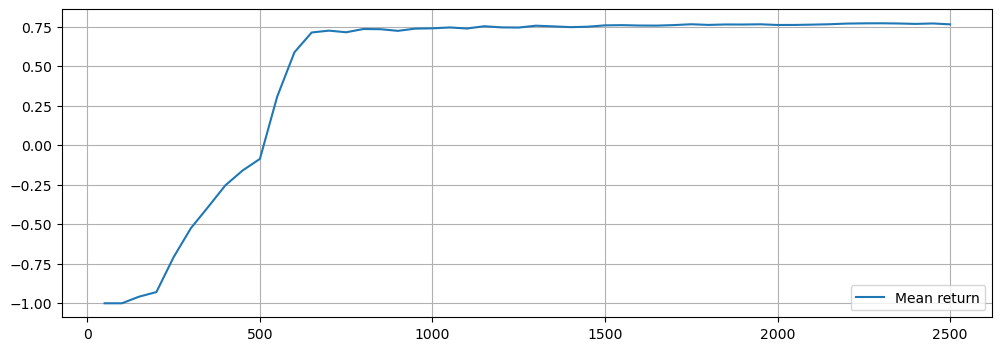

Episode: 2500, Return: 0.7801888648295346, AvgReturn[50]: 1


(0.04669747052543716, 0.03221225472000002)

In [126]:
from functools import partial

def train(env, agent, n_episodes, seed, show_progress_schedule=50, starting_episode=1):
    avg_returns, returns_batch = [], []
    rng = np.random.default_rng(seed)

    for i in range(starting_episode, starting_episode + n_episodes):
        state, _ = env.reset(seed=int(rng.integers(10000000)))
        reward, episode_return = 0, 0

        while True:
            action = agent.act(state)

            # выполняем действие в среде
            next_state, reward, terminated, truncated, info = env.step(action)
            # шаг обучения
            agent.update(state, action, reward, next_state, terminated)
            state = next_state
            episode_return += reward
            done = terminated or truncated
            if done:
                agent.reset()
                break

        returns_batch.append(episode_return)

        if i % show_progress_schedule == 0:
            avg_returns.append((i, np.mean(returns_batch)))
            returns_batch = []
            
            show_progress(avg_returns)
            print(
                f"Episode: {i}, Return: {episode_return}, "
                f"AvgReturn[{show_progress_schedule}]: {avg_returns[-1][1]:.0f}"
            )

    return avg_returns

env = make_four_rooms(
    # size=16,
    agent=sample_point_in_room(0, 12),
    terminal=sample_point_in_room(3, 12),  
    const_punish=0.01, terminal_decay=0.999,
    time_limit=100, pixel_size=2,
    observation_type='state'
)
seed = 1337
agent = QAgent(
    env.observation_space.n, env.action_space.n, gamma=0.95, seed=seed,
    lr=DecayVal(val=0.1, decay=0.97, schedule=100),
    eps=DecayVal(val=0.3, decay=0.8, schedule=250),
)

log_q = train(env, agent, n_episodes=2500, seed=seed, show_progress_schedule=50)
agent.lr(), agent.eps()

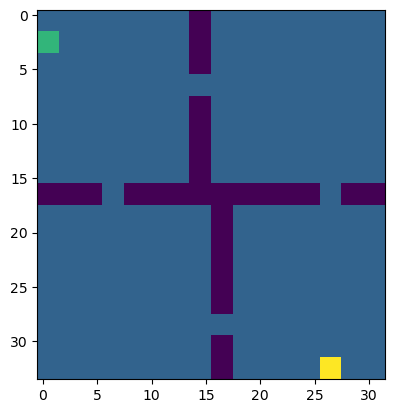

In [116]:
seeds = [[11, 15], [14, 15], [19, 21]]
seed_ind = 0
env = make_four_rooms(
    agent=sample_point_in_room(0, seeds[seed_ind][0]),
    terminal=sample_point_in_room(3, seeds[seed_ind][1]),
    const_punish=0.01, terminal_decay=0.999,
    time_limit=100, pixel_size=2,
    observation_type='state'
)
env.render_rgb()

### Q-learning sequential goal change

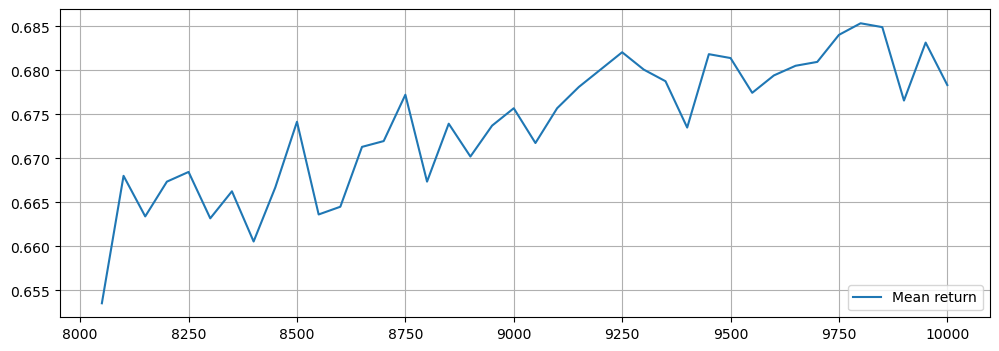

Episode: 10000, Return: 0.6814023696327183, AvgReturn[50]: 1


(0.05437943429267468, 0.05437943429267468)

In [139]:
seeds = [[11, 15], [14, 15], [19, 21]]
agent_seed = 1337
log_q = []

lr = DecayVal(val=0.1, decay=0.97, schedule=100)
eps = DecayVal(val=0.1, decay=0.97, schedule=100)

agent = QAgent(
    env.observation_space.n, env.action_space.n, gamma=0.95, seed=agent_seed,
    lr=lr.copy(),
    eps=eps.copy(),
)
for task in range(5):
    task = seeds[task % len(seeds)]
    env = make_four_rooms(
        agent=sample_point_in_room(0, task[0]),
        terminal=sample_point_in_room(3, task[1]),
        const_punish=0.01, terminal_decay=0.999,
        time_limit=100, pixel_size=2,
        observation_type='state'
    )
    agent.lr = lr.copy()
    agent.eps = eps.copy()
    total_episodes = 0 if not log_q else log_q[-1][0]
    
    log_q.extend(
        train(
            env, agent, n_episodes=2000, seed=seed, 
            show_progress_schedule=50, starting_episode=total_episodes + 1
        )
    )

agent.lr(), agent.eps()

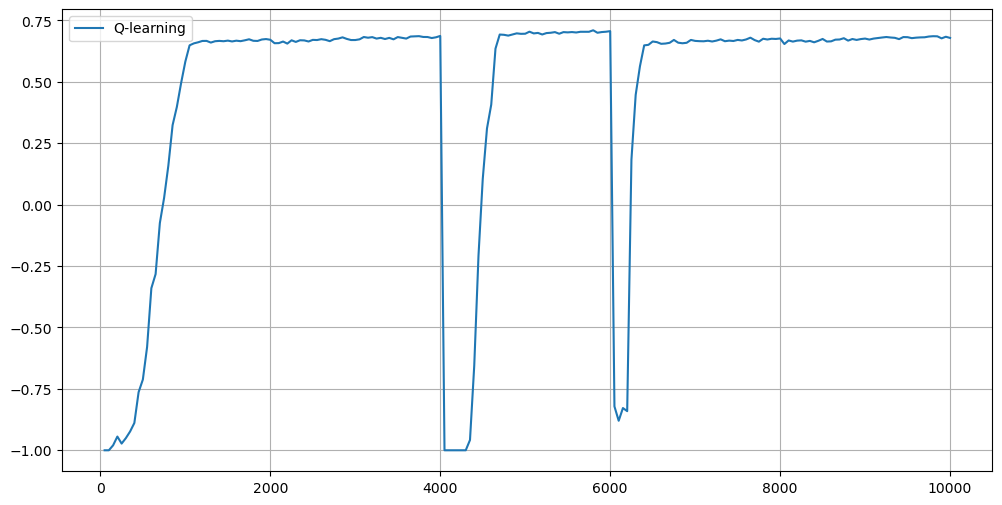

In [140]:
compare_logs([
    (log_q, 'Q-learning'),
    # (log_q_sr, 'Q-SR'),
    # (log_sarsa_sr, 'Dyna-Q imperfect model'),
])

## SR

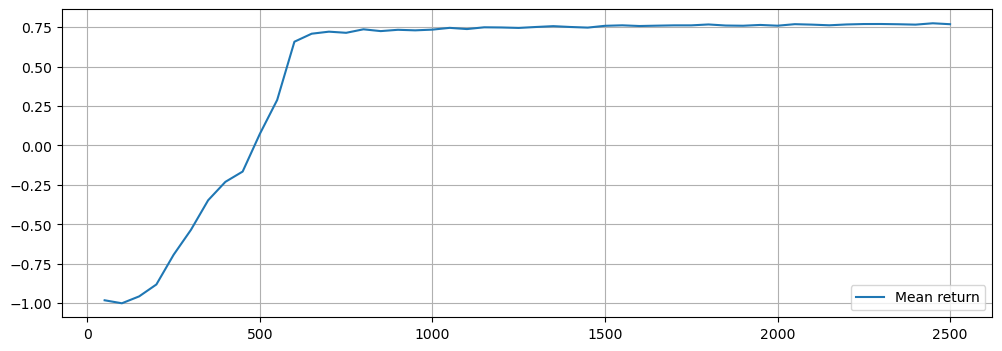

Episode: 2500, Return: 0.7801888648295346, AvgReturn[50]: 1


(0.04669747052543716, 0.03221225472000002)

In [142]:
class SrAgent:
    def __init__(self, n_states, n_actions, lr, gamma, eps, seed, sarsa=False):
        self.r = np.zeros((n_states,))
        self.M = np.zeros((n_states, n_actions, n_states))
        self.lr = lr
        self.gamma = gamma
        self.eps = eps
        self.n_actions = n_actions
        self.sarsa = sarsa
        self._rng = np.random.default_rng(seed)

    def reset(self):
        self.eps.step()
        self.lr.step()

    def Q(self, s):
        return np.dot(self.M[s], self.r)
        
    def act(self, s, greedy=False):
        # выбираем действие, используя eps-greedy исследование среды
        # с вероятностью epsilon выбираем случайное действие, иначе
        # выполняем действие жадно, согласно текущей Q-таблице
        if not greedy and self._rng.random() < self.eps():
            action = self._rng.choice(self.n_actions)
        else:
            action = np.argmax(self.Q(s))  # используем Q-функцию
        return action

    def update(self, s, a, r, s_n, done):
        # реализуйте шаг Q-обучения
        # получаем old_value (Q(s,a)) и next_max (max(Q(s', a')))
        self.r[s_n] += self.lr() * (r - self.r[s_n])

        # do I need max(M)?
        a_n = self.act(s_n, greedy=not self.sarsa)

        target = self.gamma * (1 - done) * self.M[s_n, a_n]
        target[s_n] += 1.
        
        td_error = target - self.M[s,a]
        self.M[s, a] += self.lr() * td_error

env = make_four_rooms(
    # size=16,
    agent=sample_point_in_room(0, 12),
    terminal=sample_point_in_room(3, 12),  
    const_punish=0.01, terminal_decay=0.999,
    time_limit=100, pixel_size=2,
    observation_type='state'
)
seed = 1337
agent = SrAgent(
    env.observation_space.n, env.action_space.n, gamma=0.95, seed=seed,
    lr=DecayVal(val=0.1, decay=0.97, schedule=100),
    eps=DecayVal(val=0.3, decay=0.8, schedule=250),
    sarsa=False
)

log_q_sr = train(env, agent, n_episodes=2500, seed=seed, show_progress_schedule=50)
agent.lr(), agent.eps()

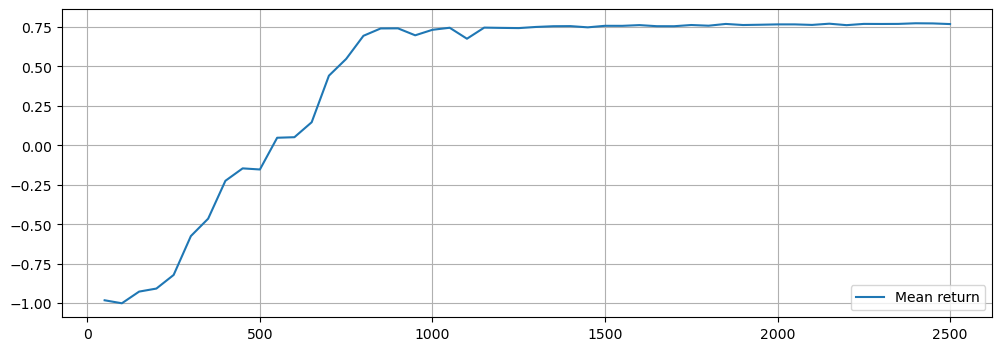

Episode: 2500, Return: 0.7582294672887403, AvgReturn[50]: 1


(0.04669747052543716, 0.03221225472000002)

In [143]:
env = make_four_rooms(
    # size=16,
    agent=sample_point_in_room(0, 12),
    terminal=sample_point_in_room(3, 12),  
    const_punish=0.01, terminal_decay=0.999,
    time_limit=100, pixel_size=2,
    observation_type='state'
)
seed = 1337
agent = SrAgent(
    env.observation_space.n, env.action_space.n, gamma=0.95, seed=seed,
    lr=DecayVal(val=0.1, decay=0.97, schedule=100),
    eps=DecayVal(val=0.3, decay=0.8, schedule=250),
    sarsa=True
)

log_sarsa_sr = train(env, agent, n_episodes=2500, seed=seed, show_progress_schedule=50)
agent.lr(), agent.eps()

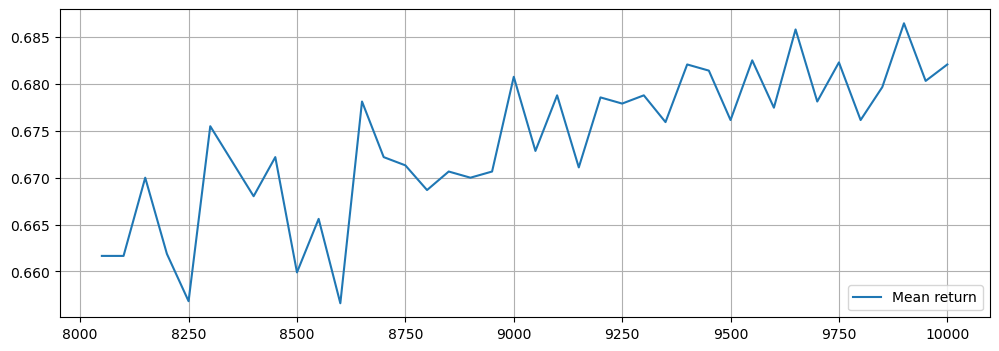

Episode: 10000, Return: 0.703348092469565, AvgReturn[50]: 1


(0.05437943429267468, 0.05437943429267468)

In [144]:
seeds = [[11, 15], [14, 15], [19, 21]]
agent_seed = 1337
log_q_sr = []

lr = DecayVal(val=0.1, decay=0.97, schedule=100)
eps = DecayVal(val=0.1, decay=0.97, schedule=100)

agent = SrAgent(
    env.observation_space.n, env.action_space.n, gamma=0.95, seed=seed,
    lr=lr.copy(),
    eps=eps.copy(),
    sarsa=False
)
for task in range(5):
    task = seeds[task % len(seeds)]
    env = make_four_rooms(
        agent=sample_point_in_room(0, task[0]),
        terminal=sample_point_in_room(3, task[1]),
        const_punish=0.01, terminal_decay=0.999,
        time_limit=100, pixel_size=2,
        observation_type='state'
    )
    agent.lr = lr.copy()
    agent.eps = eps.copy()
    total_episodes = 0 if not log_q_sr else log_q_sr[-1][0]
    
    log_q_sr.extend(
        train(
            env, agent, n_episodes=2000, seed=seed, 
            show_progress_schedule=50, starting_episode=total_episodes + 1
        )
    )

agent.lr(), agent.eps()

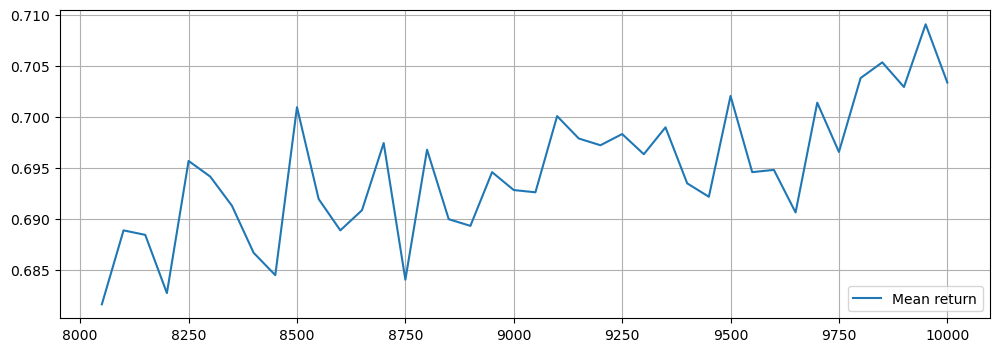

Episode: 10000, Return: 0.7252977125970465, AvgReturn[50]: 1


(0.05437943429267468, 0.05437943429267468)

In [145]:
seeds = [[11, 15], [14, 15], [19, 21]]
agent_seed = 1337
log_sarsa_sr = []

lr = DecayVal(val=0.1, decay=0.97, schedule=100)
eps = DecayVal(val=0.1, decay=0.97, schedule=100)

agent = SrAgent(
    env.observation_space.n, env.action_space.n, gamma=0.95, seed=seed,
    lr=lr.copy(),
    eps=eps.copy(),
    sarsa=True
)
for task in range(5):
    task = seeds[task % len(seeds)]
    env = make_four_rooms(
        agent=sample_point_in_room(0, task[0]),
        terminal=sample_point_in_room(3, task[1]),
        const_punish=0.01, terminal_decay=0.999,
        time_limit=100, pixel_size=2,
        observation_type='state'
    )
    agent.lr = lr.copy()
    agent.eps = eps.copy()
    total_episodes = 0 if not log_sarsa_sr else log_sarsa_sr[-1][0]
    
    log_sarsa_sr.extend(
        train(
            env, agent, n_episodes=2000, seed=seed, 
            show_progress_schedule=50, starting_episode=total_episodes + 1
        )
    )

agent.lr(), agent.eps()

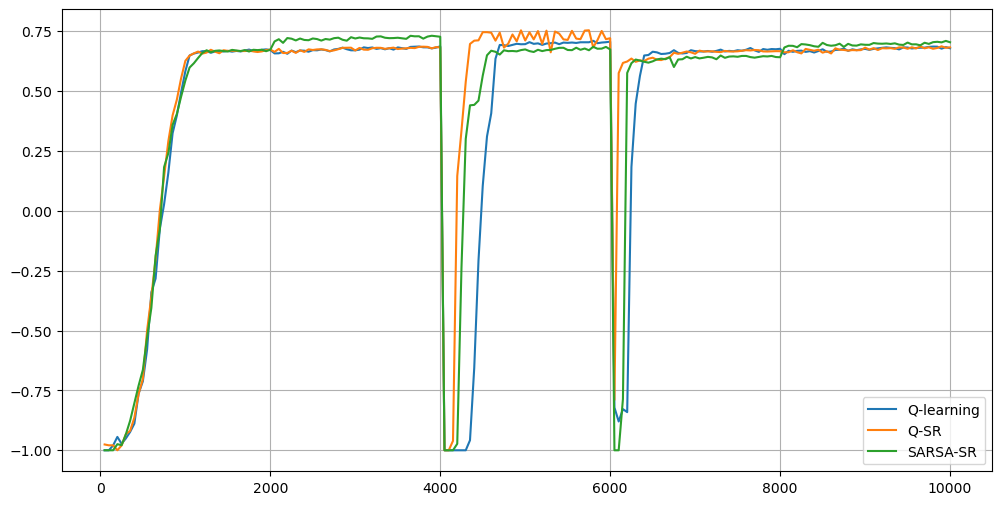

In [147]:
compare_logs([
    (log_q, 'Q-learning'),
    (log_q_sr, 'Q-SR'),
    (log_sarsa_sr, 'SARSA-SR'),
])

In [57]:
from IPython.display import Video
from IPython import display

def show_video(path):
    display(Video(path, embed=True))